In [1]:
import glob
from warnings import simplefilter
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import astropy.units as u
from astropy import constants as const
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm
from scipy import integrate
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.ParserWarning)


In [3]:
def clean_cloudy_con_file(filename):
    '''
    My method for making cloudy continuum files which are run on a single grid
    more user friendly. 
    '''
    df = pd.read_csv(filename, delimiter='\t+', comment='##')
    df = df.rename(columns={'#Cont  nu':'wave'})
    # df['step'] = np.zeros(len(df['wave']))
    # df['step'] = pd.qcut(df.index, int(len(df['wave'])/df['wave'].nunique()))
    # df['step'] = df['step'].cat.rename_categories(np.arange(0,len(df['step'].unique())))
    
    return df

def get_wavelength_from_ev(energy_eV):
    '''
    Takes photon energy in eV and returns corresponding wavelength in Angstroms
    '''
    return (const.h*const.c/(energy_eV*u.eV)).to(u.Angstrom).value

def format_bpass_sed(path):
    df = pd.read_csv(path, delimiter='\s+', header=None) 
    df.columns = (df.columns-1)/10 + 6
    df = df.rename(columns = {5.9:'wavelength'})
    return(df)

very_high_upper = get_wavelength_from_ev(54.42)
high_lower = get_wavelength_from_ev(54.93)
high_upper = get_wavelength_from_ev(35.11)
intermediate_lower = get_wavelength_from_ev(34.79)
intermediate_upper = get_wavelength_from_ev(23.33)
low_lower = get_wavelength_from_ev(29.60)
low_upper = get_wavelength_from_ev(14.53)

def generate_ionization_zones_plot(ax, df, age, show_annotations=False):

    x_total = df['wavelength'][df.wavelength < 912]
    y_total = df[age][df.wavelength < 912]
    x_low = df['wavelength'][(df.wavelength > low_lower)&(df.wavelength < low_upper)]
    y_low = df[age][(df.wavelength > low_lower)&(df.wavelength < low_upper)]
    x_intermediate = df['wavelength'][(df.wavelength > intermediate_lower)&(df.wavelength < intermediate_upper)]
    y_intermediate = df[age][(df.wavelength > intermediate_lower)&(df.wavelength < intermediate_upper)]
    x_high = df['wavelength'][(df.wavelength > high_lower)&(df.wavelength < high_upper)]
    y_high = df[age][(df.wavelength > high_lower)&(df.wavelength < high_upper)]
    x_very_high = df['wavelength'][(df.wavelength < very_high_upper)]
    y_very_high = df[age][(df.wavelength < very_high_upper)]

    ax.plot(x_total, y_total, color='k', alpha=0.25)
    ax.plot(x_low, y_low, color='violet', lw=3, alpha=0.7)
    ax.plot(x_intermediate, y_intermediate, color='goldenrod', lw=3, alpha=0.7)
    ax.plot(x_high, y_high, color='limegreen', lw=3, alpha=0.7)
    ax.plot(x_very_high, y_very_high, color='skyblue', lw=3, alpha=0.7)
    
    if show_annotations:
        ax.annotate(f'total = {np.format_float_scientific(integrate.trapezoid(y_total, x=x_total), precision=2)}', (0.975, 0.9), xycoords='axes fraction', ha='right')
        ax.annotate(f'low = {np.format_float_scientific(integrate.trapezoid(y_low, x=x_low), precision=2)}', (0.975, 0.85), xycoords='axes fraction', ha='right', color='violet')
        ax.annotate(f'intermediate = {np.format_float_scientific(integrate.trapezoid(y_intermediate, x=x_intermediate), precision=2)}', (0.975, 0.8), xycoords='axes fraction', ha='right', color='goldenrod')
        ax.annotate(f'high = {np.format_float_scientific(integrate.trapezoid(y_high, x=x_high), precision=2)}', (0.975, 0.75), xycoords='axes fraction', ha='right', color='limegreen')
        ax.annotate(f'very high = {np.format_float_scientific(integrate.trapezoid(y_very_high, x=x_very_high), precision=2)}', (0.975, 0.7), xycoords='axes fraction', ha='right',  color='skyblue')
    else:
        ax.annotate(f'Low', (0.975, 0.85), xycoords='axes fraction', ha='right', color='violet')
        ax.annotate(f'Intermediate', (0.975, 0.8), xycoords='axes fraction', ha='right', color='goldenrod')
        ax.annotate(f'High', (0.975, 0.75), xycoords='axes fraction', ha='right', color='limegreen')
        ax.annotate(f'Very High', (0.975, 0.7), xycoords='axes fraction', ha='right',  color='skyblue')
        
def generate_ionization_zone_integrals(seds):
    sed_integrals = pd.DataFrame(index=['total', 'low', 'intermediate', 'high', 'very_high'])

    ages = np.round(np.arange(6, 11.1, 0.1), decimals=1)
    for age in ages: 

        x_total = seds['wavelength'][seds.wavelength < 912]
        y_total = seds[age][seds.wavelength < 912]
        x_low = seds['wavelength'][(seds.wavelength > low_lower)&(seds.wavelength < low_upper)]
        y_low = seds[age][(seds.wavelength > low_lower)&(seds.wavelength < low_upper)]
        x_intermediate = seds['wavelength'][(seds.wavelength > intermediate_lower)&(seds.wavelength < intermediate_upper)]
        y_intermediate = seds[age][(seds.wavelength > intermediate_lower)&(seds.wavelength < intermediate_upper)]
        x_high = seds['wavelength'][(seds.wavelength > high_lower)&(seds.wavelength < high_upper)]
        y_high = seds[age][(seds.wavelength > high_lower)&(seds.wavelength < high_upper)]
        x_very_high = seds['wavelength'][(seds.wavelength < very_high_upper)]
        y_very_high = seds[age][(seds.wavelength < very_high_upper)]

        integral_total = integrate.trapezoid(y_total, x=x_total)
        integral_low = integrate.trapezoid(y_low, x=x_low)
        integral_intermediate = integrate.trapezoid(y_intermediate, x=x_intermediate)
        integral_high = integrate.trapezoid(y_high, x=x_high)
        integral_very_high = integrate.trapezoid(y_very_high, x=x_very_high)

        sed_integrals[age] = {
            'total':integral_total,
            'low':integral_low, 
            'intermediate':integral_intermediate,
            'high':integral_high,
            'very_high':integral_very_high
        }

    return sed_integrals

def generate_ionization_zone_integrals_mbh(seds):
    sed_integrals = pd.DataFrame(index=['total', 'low', 'intermediate', 'high', 'very_high'])

    mbhs = [3,4,5,6,7,8,9]
    for mbh in mbhs: 

        x_total = seds['wavelength'][seds.wavelength < 912]
        y_total = seds[mbh][seds.wavelength < 912]
        x_low = seds['wavelength'][(seds.wavelength > low_lower)&(seds.wavelength < low_upper)]
        y_low = seds[mbh][(seds.wavelength > low_lower)&(seds.wavelength < low_upper)]
        x_intermediate = seds['wavelength'][(seds.wavelength > intermediate_lower)&(seds.wavelength < intermediate_upper)]
        y_intermediate = seds[mbh][(seds.wavelength > intermediate_lower)&(seds.wavelength < intermediate_upper)]
        x_high = seds['wavelength'][(seds.wavelength > high_lower)&(seds.wavelength < high_upper)]
        y_high = seds[mbh][(seds.wavelength > high_lower)&(seds.wavelength < high_upper)]
        x_very_high = seds['wavelength'][(seds.wavelength < very_high_upper)]
        y_very_high = seds[mbh][(seds.wavelength < very_high_upper)]

        integral_total = integrate.trapezoid(y_total, x=x_total)
        integral_low = integrate.trapezoid(y_low, x=x_low)
        integral_intermediate = integrate.trapezoid(y_intermediate, x=x_intermediate)
        integral_high = integrate.trapezoid(y_high, x=x_high)
        integral_very_high = integrate.trapezoid(y_very_high, x=x_very_high)

        sed_integrals[mbh] = {
            'total':integral_total,
            'low':integral_low, 
            'intermediate':integral_intermediate,
            'high':integral_high,
            'very_high':integral_very_high
        }

    return -1*sed_integrals

In [8]:
BPASS_seds = '/Users/njc5787/Research/BPASSv2.2.1_release-07-18-Tuatara/seds_300/bpass_v2.2.1_imf135_300/'

BPASS_135_300_binarydf = format_bpass_sed(BPASS_seds+'spectra-bin-imf135_300.z001.dat')
integrals_df = generate_ionization_zone_integrals(seds=BPASS_135_300_binarydf)

In [9]:
Z_ALL = ['em5', 'em4', '001', '002', '003', '004', '006', '008', '010', '014', '020', '040']

z_size = np.linspace(10, 300, len(Z_ALL))
for z in Z_ALL:
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)

AGN_SEDs = '/Users/njc5787/Research/cloudy_modeling/agn_seds/'
mbhs = [3,4,5,6,7,8,9]
mbh_seds = pd.DataFrame()
for mbh in mbhs:
    df = pd.read_csv(AGN_SEDs+f'mbh{mbh}.txt', sep='\t+', names=['nu', 'nuFnu', 'other']).drop(0, axis=0).drop('other', axis=1).astype(float)
    mbh_seds[mbh] = df['nuFnu']
mbh_seds['wavelength'] = 2.99792e18/df['nu']
mbh_integrals = generate_ionization_zone_integrals_mbh(mbh_seds)

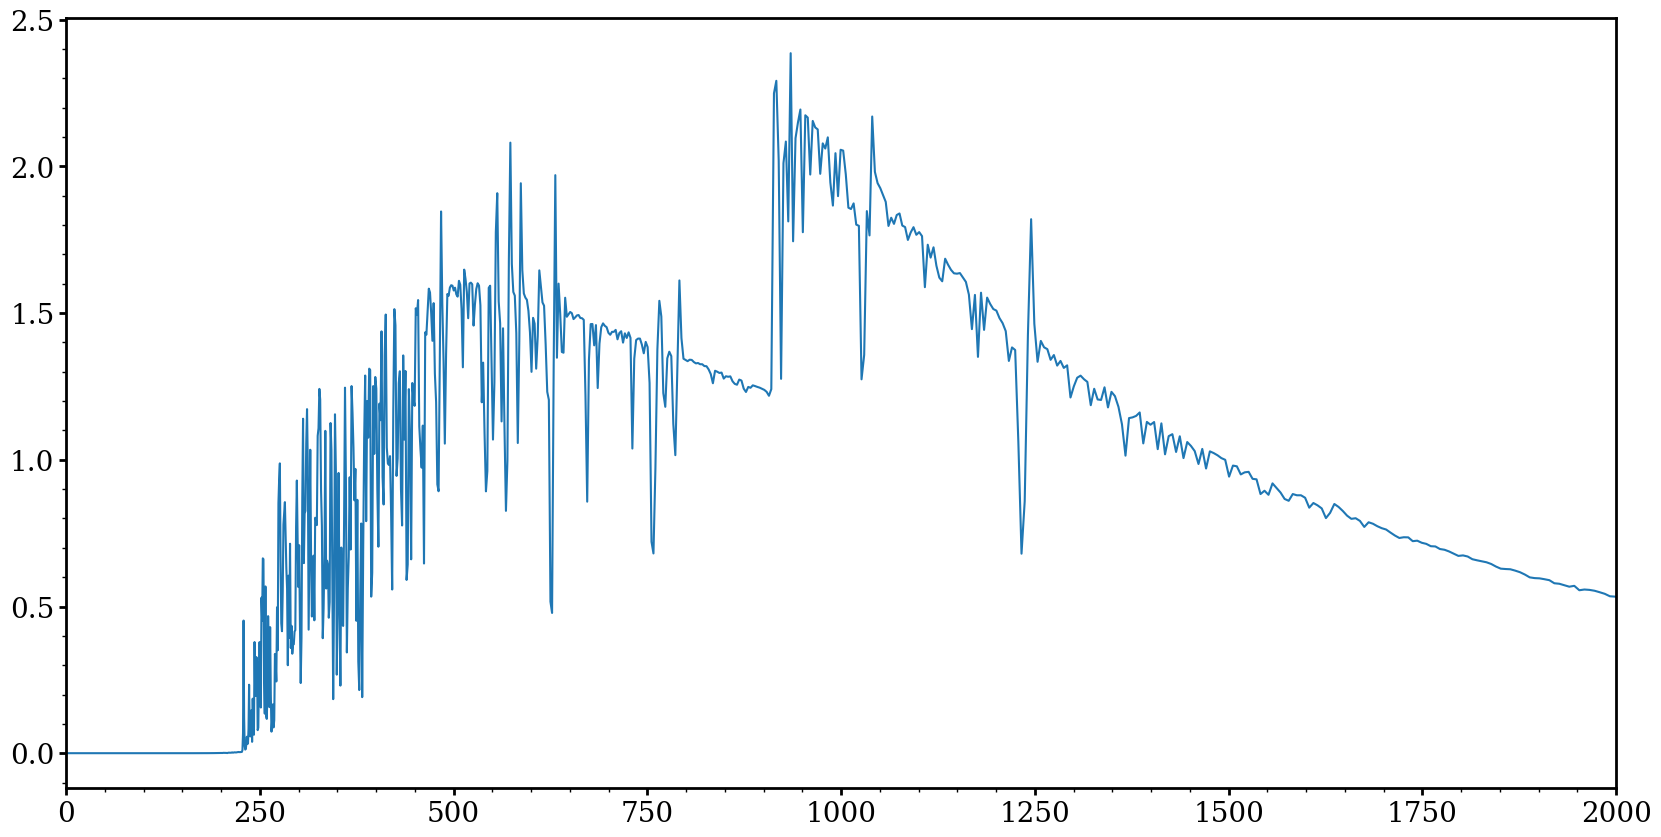

In [10]:
BPASS_135_300_single_hden3_path = "/Users/njc5787/Research/cloudy_model_library/cloudy_model_library_complete/BPASS/solar_abundances/hden3/BPASSv2.2.1_imf135_300_burst_single_models/"
path_string = "/Users/njc5787/Research/cloudy_model_library/cloudy_model_library_complete/BPASS/solar_abundances/hden2/BPASSv2.2.1_imf_chab300_burst_binary_models/sedBPASSv2.2.1_imf_chab300_burst_binary.ascii_age6.0_zstar0.1_hden2_z0.1_logU-1.5.con"
df = clean_cloudy_con_file(path_string)

plt.figure(figsize=(20, 10))
plt.plot(df.wave, np.array(df['incident'])/df[df.wave == 1.49553e+03]['incident'].iloc[0])

plt.xlim(0, 2000)
plt.show()

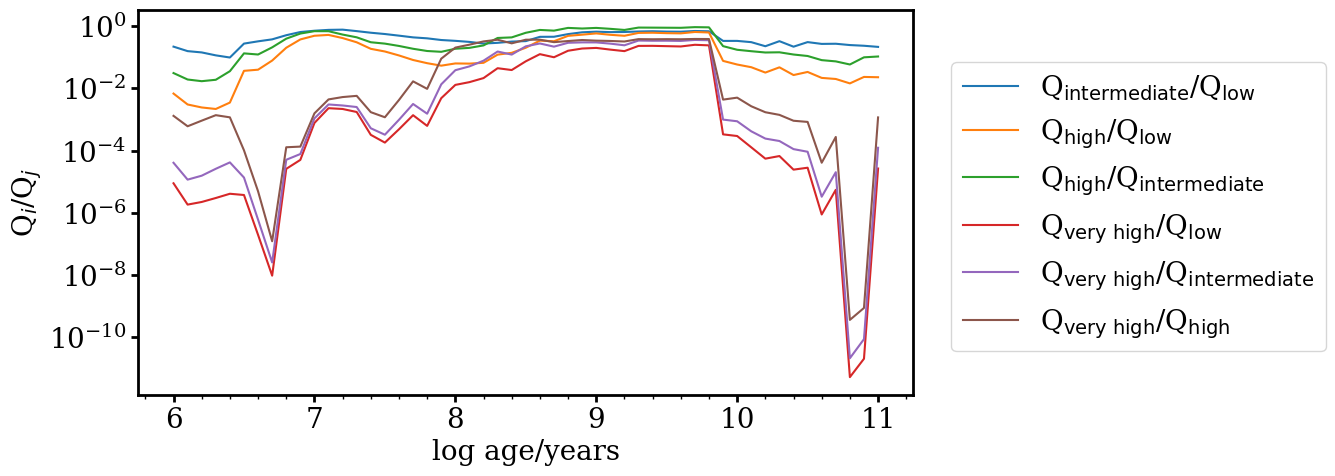

In [31]:
plt.figure(figsize=(10,5))
plt.plot(integrals_df.columns, integrals_df.loc['intermediate']/integrals_df.loc['low'], label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$')
plt.plot(integrals_df.columns, integrals_df.loc['high']/integrals_df.loc['low'], label=r'Q$_{\rm{high}}$/Q$_{\rm{low}}$')
plt.plot(integrals_df.columns, integrals_df.loc['high']/integrals_df.loc['intermediate'], label=r'Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$')
plt.plot(integrals_df.columns, integrals_df.loc['very_high']/integrals_df.loc['low'], label=r'Q$_{\rm{very~high}}$/Q$_{\rm{low}}$')
plt.plot(integrals_df.columns, integrals_df.loc['very_high']/integrals_df.loc['intermediate'], label=r'Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$')
plt.plot(integrals_df.columns, integrals_df.loc['very_high']/integrals_df.loc['high'], label=r'Q$_{\rm{very~high}}$/Q$_{\rm{high}}$')


plt.yscale('log')
# plt.ylim(1e0, 1e10)
plt.xlabel('log age/years')
plt.ylabel('Q$_{i}$/Q$_{j}$')
plt.legend(bbox_to_anchor=(1.55, 0.9))

plt.show()

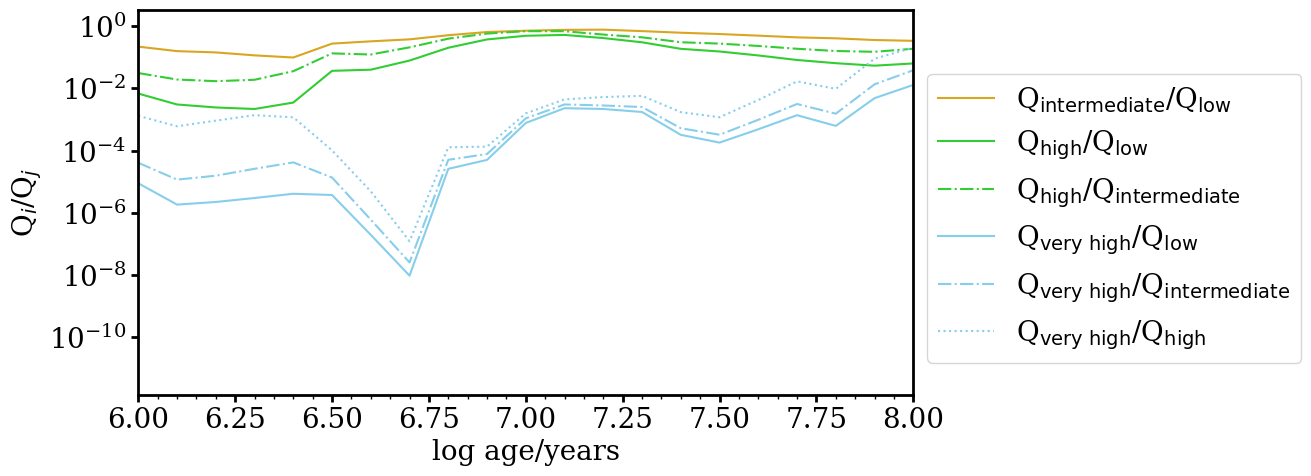

In [43]:
plt.figure(figsize=(10,5))
plt.plot(integrals_df.columns, integrals_df.loc['intermediate']/integrals_df.loc['low'], label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$', ls='-', c='goldenrod')
plt.plot(integrals_df.columns, integrals_df.loc['high']/integrals_df.loc['low'], label=r'Q$_{\rm{high}}$/Q$_{\rm{low}}$', ls='-', c='limegreen')
plt.plot(integrals_df.columns, integrals_df.loc['high']/integrals_df.loc['intermediate'], label=r'Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$', ls='-.', c='limegreen')
plt.plot(integrals_df.columns, integrals_df.loc['very_high']/integrals_df.loc['low'], label=r'Q$_{\rm{very~high}}$/Q$_{\rm{low}}$', ls='-', c='skyblue')
plt.plot(integrals_df.columns, integrals_df.loc['very_high']/integrals_df.loc['intermediate'], label=r'Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$', ls='-.', c='skyblue')
plt.plot(integrals_df.columns, integrals_df.loc['very_high']/integrals_df.loc['high'], label=r'Q$_{\rm{very~high}}$/Q$_{\rm{high}}$', ls=':', c='skyblue')


plt.yscale('log')
plt.xlim(6, 8)
# plt.ylim(1e0, 1e10)
plt.xlabel('log age/years')
plt.ylabel('Q$_{i}$/Q$_{j}$')
plt.legend(bbox_to_anchor=(1.0, 0.87))

plt.show()

In [2]:
all_models_with_qs = pd.read_csv('all_models_with_qs.csv', index_col=0)

bpass_models_with_qs = all_models_with_qs[all_models_with_qs.mbh.isna()]
mbh_models_with_qs = all_models_with_qs[all_models_with_qs.mbh.notna()]


/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_14869/1978747815.py:1: DtypeWarning: Columns (211,212,213,214) have mixed types. Specify dtype option on import or set low_memory=False.
  all_models_with_qs = pd.read_csv('all_models_with_qs.csv', index_col=0)


In [12]:
bpass_models_with_qs

,N_4_765.147A,N_3_991.000A,C_3_977.020A,C_2_904.142A,C_2_1036.34A,C_2_1037.02A,S_4_1062.66A,H_1_1215.68A,N_5_1238.82A,N_5_1242.80A,...,sed,binary_or_single,history,imf,Q_total,Q_low,Q_intermediate,Q_high,Q_very_high,mbh
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age7.1_zstar0.1_hden3_z0.1_logU-2.75,4.609400e-05,8.455600e-06,0.003117,1.185800e-04,9.388400e-04,0.001190,1.126800e-04,0.823320,1.150800e-07,5.956600e-08,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,6.181809e+06,3.840057e+06,1.949325e+06,1.141909e+06,4.024118e+04,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age6.1_zstar0.4_hden3_z0.4_logU-3.75,1.747100e-09,8.054900e-10,0.000031,1.427100e-05,1.760400e-05,0.000022,2.816100e-09,0.058002,0.000000e+00,0.000000e+00,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,1.600474e+08,1.232513e+08,4.747371e+07,1.073280e+07,1.250047e+04,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age7.2_zstar2.0_hden3_z2.0_logU-1.25,1.269500e-03,1.661200e-02,0.038420,2.014700e-03,1.379200e-02,0.016849,1.904100e-02,1.094000,1.665900e-03,8.743800e-04,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,1.305911e+06,7.123009e+05,5.483304e+05,2.932462e+05,1.540309e+03,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age7.8_zstar0.05_hden3_z0.05_logU-2.0,3.519800e-04,1.406100e-04,0.039419,5.035800e-04,1.736400e-02,0.022059,1.149800e-02,3.939400,3.767800e-06,1.998000e-06,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,2.768973e+05,1.930144e+05,9.473766e+04,3.919922e+04,4.037895e+02,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age6.9_zstar0.5_hden3_z0.5_logU-3.75,7.905100e-09,3.739600e-09,0.000144,1.711300e-05,8.910000e-05,0.000112,3.836100e-08,0.066223,0.000000e+00,0.000000e+00,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,7.990522e+06,5.208316e+06,2.417780e+06,1.162595e+06,7.208846e+02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hden2/BPASSv2.2.1_imf100_300_burst_binary_models/sedBPASSv2.2.1_imf100_300_burst_binary.ascii_age6.6_zstar0.0005_hden2_z0.0005_logU-1.0,1.295400e-03,1.396900e-05,0.004587,2.149500e-05,9.575700e-05,0.000198,3.915700e-04,4.634100,8.152500e-07,4.286900e-07,...,BPASSv2.2.1_imf100_300_burst_binary.ascii,binary,burst,100_300,1.122225e+09,6.309305e+08,3.502839e+08,2.879397e+08,3.661306e+06,NaN
hden2/BPASSv2.2.1_imf100_300_burst_binary_models/sedBPASSv2.2.1_imf100_300_burst_binary.ascii_age8.5_zstar0.005_hden2_z0.005_logU-1.25,8.493500e-04,4.825900e-05,0.034205,2.433400e-04,3.686800e-02,0.043710,7.904100e-02,2.561400,5.009900e-03,3.176600e-03,...,BPASSv2.2.1_imf100_300_burst_binary.ascii,binary,burst,100_300,3.792314e+03,2.624152e+03,8.105031e+02,4.580715e+02,8.940054e+01,NaN
hden2/BPASSv2.2.1_imf100_300_burst_binary_models/sedBPASSv2.2.1_imf100_300_burst_binary.ascii_age6.7_zstar0.15_hden2_z0.15_logU-2.0,7.961500e-05,3.277300e-05,0.001362,9.033500e-05,1.306900e-04,0.000232,5.177500e-05,0.249730,1.434200e-07,8.408900e-08,...,BPASSv2.2.1_imf100_300_burst_binary.ascii,binary,burst,100_300,3.668646e+08,2.523652e+08,1.013754e+08,4.980653e+07,7.198913e+05,NaN
hden2/BPASSv2.2.1_imf100_300_burst_binary_models/sedBPASSv2.2.1_imf100_300_burst_binary.ascii_age10.0_zstar0.15_hden2_z0.15_logU-4.0,1.293800e-10,1.647100e-10,0.000002,3.841600e-07,8.947600e-07,0.000002,1.541900e-10,0.004772,0.000000e+00,0.000000e+00,...,BPASSv2.2.1_imf100_300_burst_binary.ascii,binary,burst,100_300,5.826590e+01,2.975097e+01,1.751932e+01,1.438198e+01,4.721722e+00,NaN


In [13]:
mbh_models_with_qs

,N_4_765.147A,N_3_991.000A,C_3_977.020A,C_2_904.142A,C_2_1036.34A,C_2_1037.02A,S_4_1062.66A,H_1_1215.68A,N_5_1238.82A,N_5_1242.80A,...,sed,binary_or_single,history,imf,Q_total,Q_low,Q_intermediate,Q_high,Q_very_high,mbh
mbh9/sedmbh9_hden4_z0.7_logU-1.0,0.139460,0.100080,0.633390,0.100880,0.080780,0.094715,0.045843,14.89300,5.480100e-02,3.911400e-02,...,NaN,NaN,NaN,NaN,4.385479e+18,3.824260e+18,7.926575e+17,1.409921e+17,1.424800e+16,9.0
mbh9/sedmbh9_hden4_z0.5_logU-1.75,0.016113,0.008054,0.108340,0.020640,0.019637,0.022218,0.006772,14.34100,4.247400e-04,2.151100e-04,...,NaN,NaN,NaN,NaN,4.385479e+18,3.824260e+18,7.926575e+17,1.409921e+17,1.424800e+16,9.0
mbh9/sedmbh9_hden2_z0.4_logU-1.75,0.000153,0.000065,0.001035,0.000223,0.000162,0.000251,0.000054,0.13378,3.208100e-06,1.620700e-06,...,NaN,NaN,NaN,NaN,4.385479e+18,3.824260e+18,7.926575e+17,1.409921e+17,1.424800e+16,9.0
mbh9/sedmbh9_hden2_z0.5_logU-2.25,0.000034,0.000008,0.000253,0.000072,0.000052,0.000081,0.000014,0.07939,9.340500e-08,4.684000e-08,...,NaN,NaN,NaN,NaN,4.385479e+18,3.824260e+18,7.926575e+17,1.409921e+17,1.424800e+16,9.0
mbh9/sedmbh9_hden4_z0.4_logU-2.25,0.003679,0.000777,0.026435,0.006531,0.006562,0.007343,0.001508,10.73900,9.199100e-06,4.612700e-06,...,NaN,NaN,NaN,NaN,4.385479e+18,3.824260e+18,7.926575e+17,1.409921e+17,1.424800e+16,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mbh5/sedmbh5_hden3_z0.5_logU-1.5,0.032099,0.007622,0.174860,0.000990,0.000869,0.000989,0.000615,6.01460,3.224200e-01,2.351300e-01,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0
mbh5/sedmbh5_hden3_z0.3_logU-1.25,0.120260,0.007046,0.291840,0.001831,0.001165,0.001418,0.000774,8.08560,6.504700e-01,4.641700e-01,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0
mbh5/sedmbh5_hden2_z0.4_logU-1.5,0.003917,0.000675,0.019803,0.000125,0.000078,0.000132,0.000063,0.70131,3.412700e-02,2.452800e-02,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0
mbh5/sedmbh5_hden3_z0.1_logU-2.0,0.009330,0.001183,0.099707,0.000460,0.000511,0.000626,0.000442,13.00100,6.349500e-02,3.588800e-02,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0


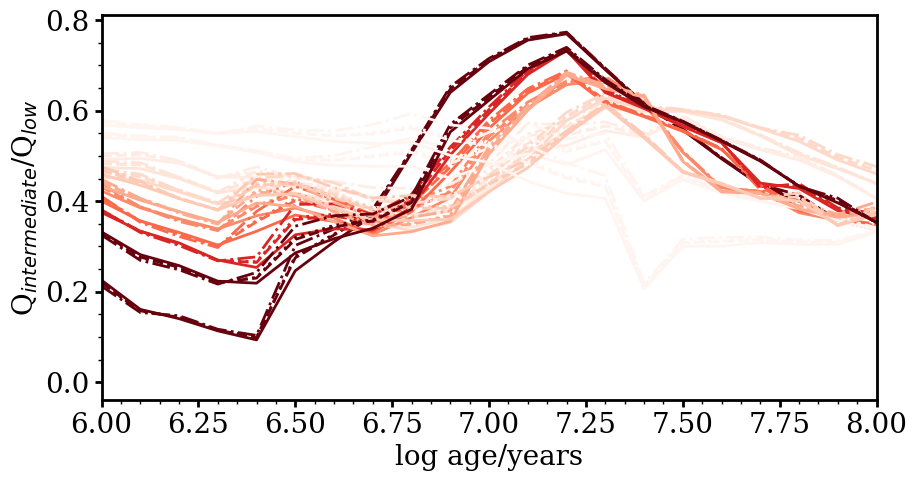

In [36]:
norm = mpl.colors.Normalize(vmin=0, vmax=2)
linestyles_imf = {
    '170_300':'-',
    '135_300':'--',
    '100_300':'-.',
    '_chab300':':'
}
plt.figure(figsize=(10,5))
for z in bpass_models_with_qs.zgas.unique(): 
    for imf in bpass_models_with_qs.imf.unique():
        model = bpass_models_with_qs[(bpass_models_with_qs.zgas == z)&(bpass_models_with_qs.imf == imf)].sort_values('age')
        # plt.plot(model['age'], model['Q_intermediate']/model['Q_low'], label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$', ls=linestyles_imf[imf], c='k', lw=2.0)
        plt.plot(model['age'], model['Q_intermediate']/model['Q_low'], label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$', ls=linestyles_imf[imf], c=plt.cm.Reds(z), lw=2)
        

# plt.scatter(bpass_models_with_qs.age, bpass_models_with_qs['Q_intermediate']/bpass_models_with_qs['Q_low'], label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$', ls='-', c=bpass_models_with_qs['zgas'], cmap='Reds')
plt.xlabel('log age/years')
plt.ylabel('Q$_{intermediate}$/Q$_{low}$')
# plt.legend(bbox_to_anchor=(1.0, 0.87))
plt.xlim(6,8)
plt.show()

array(['170_300', '135_300', '100_300', '_chab300'], dtype=object)

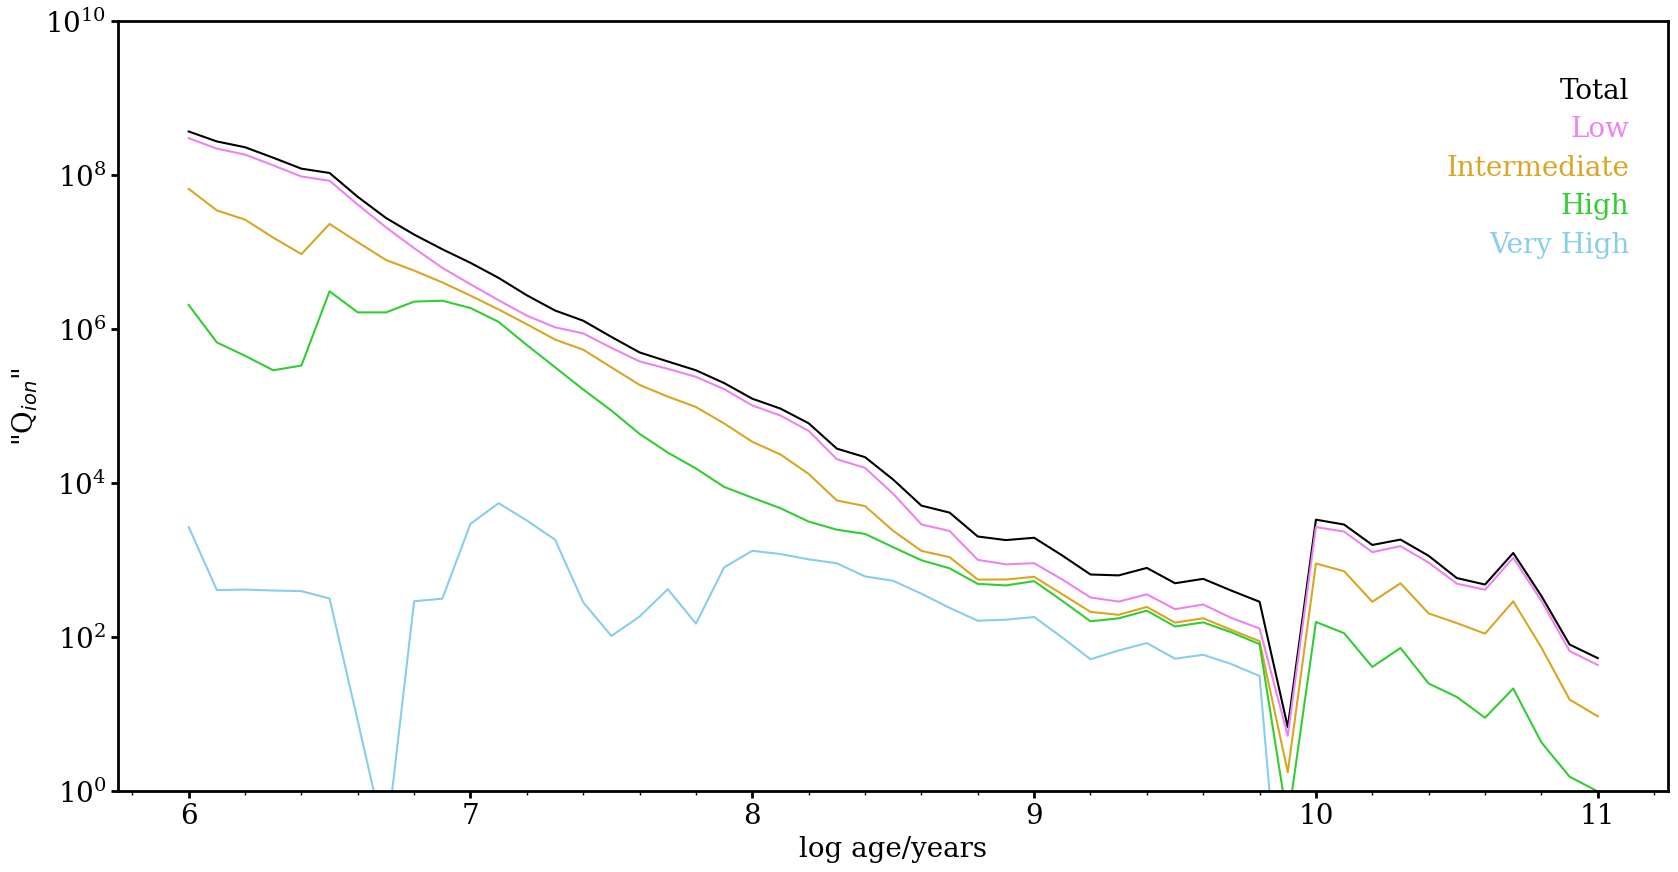

In [8]:
plt.figure(figsize=(20,10))
plt.plot(integrals_df.columns, integrals_df.loc['total'], c='k')
plt.plot(integrals_df.columns, integrals_df.loc['low'], c='violet')
plt.plot(integrals_df.columns, integrals_df.loc['intermediate'], c='goldenrod')
plt.plot(integrals_df.columns, integrals_df.loc['high'], c='limegreen')
plt.plot(integrals_df.columns, integrals_df.loc['very_high'], c='skyblue')

plt.annotate(f'Total', (0.975, 0.9), xycoords='axes fraction', ha='right', color='k')
plt.annotate(f'Low', (0.975, 0.85), xycoords='axes fraction', ha='right', color='violet')
plt.annotate(f'Intermediate', (0.975, 0.8), xycoords='axes fraction', ha='right', color='goldenrod')
plt.annotate(f'High', (0.975, 0.75), xycoords='axes fraction', ha='right', color='limegreen')
plt.annotate(f'Very High', (0.975, 0.7), xycoords='axes fraction', ha='right',  color='skyblue')

plt.yscale('log')
plt.ylim(1e0, 1e10)
plt.xlabel('log age/years')
plt.ylabel('\"Q$_{ion}$\"')

plt.show()

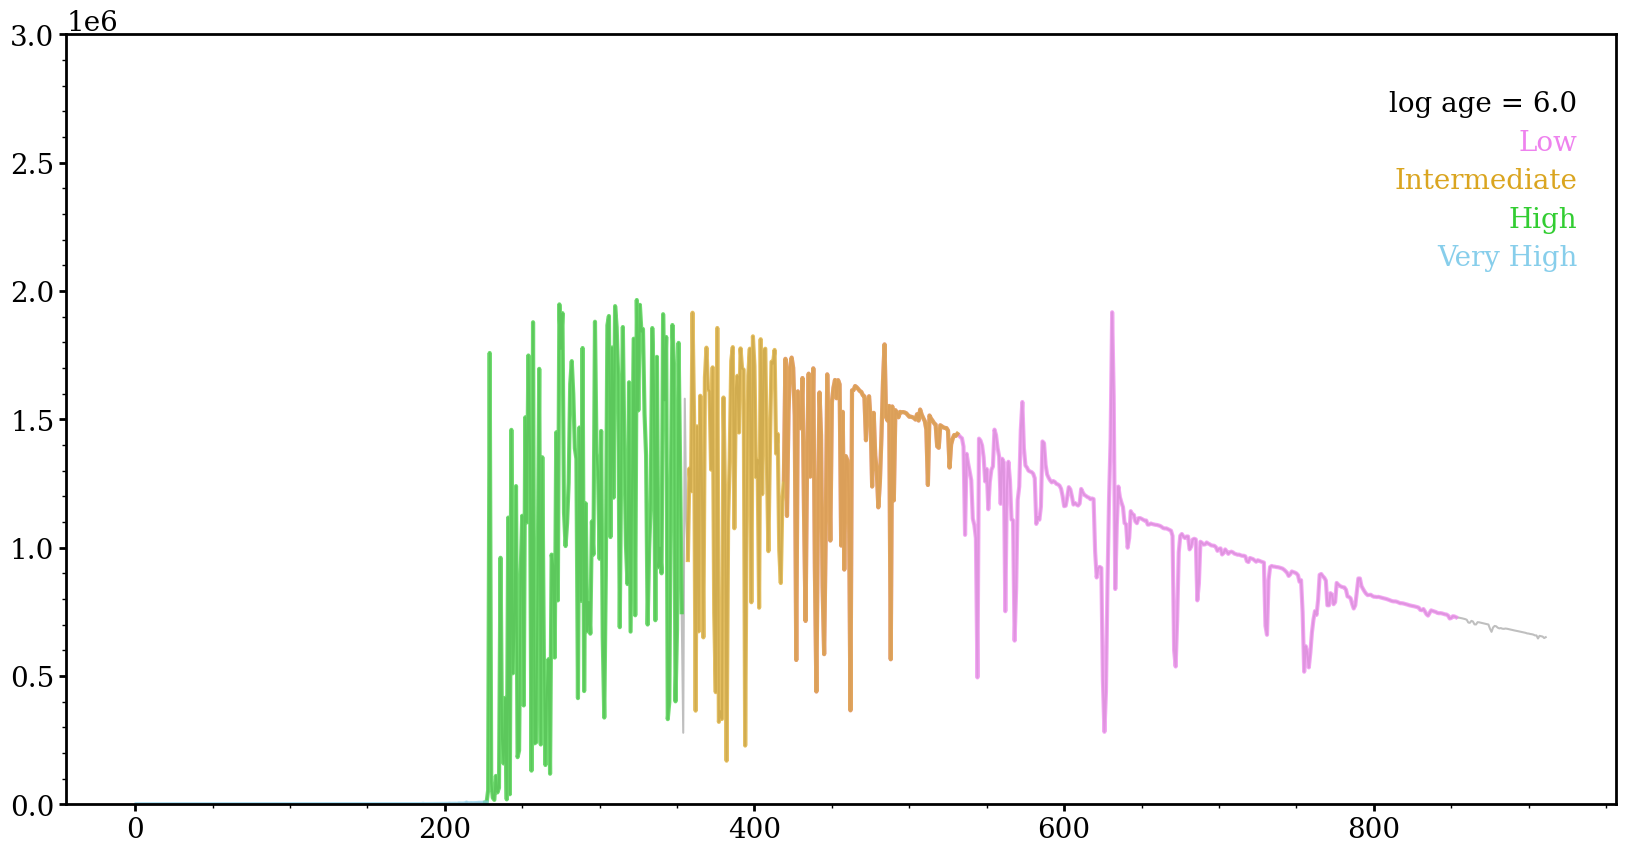

In [9]:
def animate(frame):
    ax.clear()
    age=ages[frame]
    generate_ionization_zones_plot(ax=ax, df=BPASS_135_300_binarydf, age=age)
    ax.annotate(f'log age = {age}', (0.975, 0.90), xycoords='axes fraction', ha='right')
    ax.set_ylim(0, 3e6)

ages = np.round(np.arange(6, 11.1, 0.1), decimals=1)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,10)

ani = FuncAnimation(fig, animate, frames=len(ages), interval=10, repeat=True)
ani.save('bpass_ages_new.gif', dpi=300, writer=PillowWriter(fps=5))

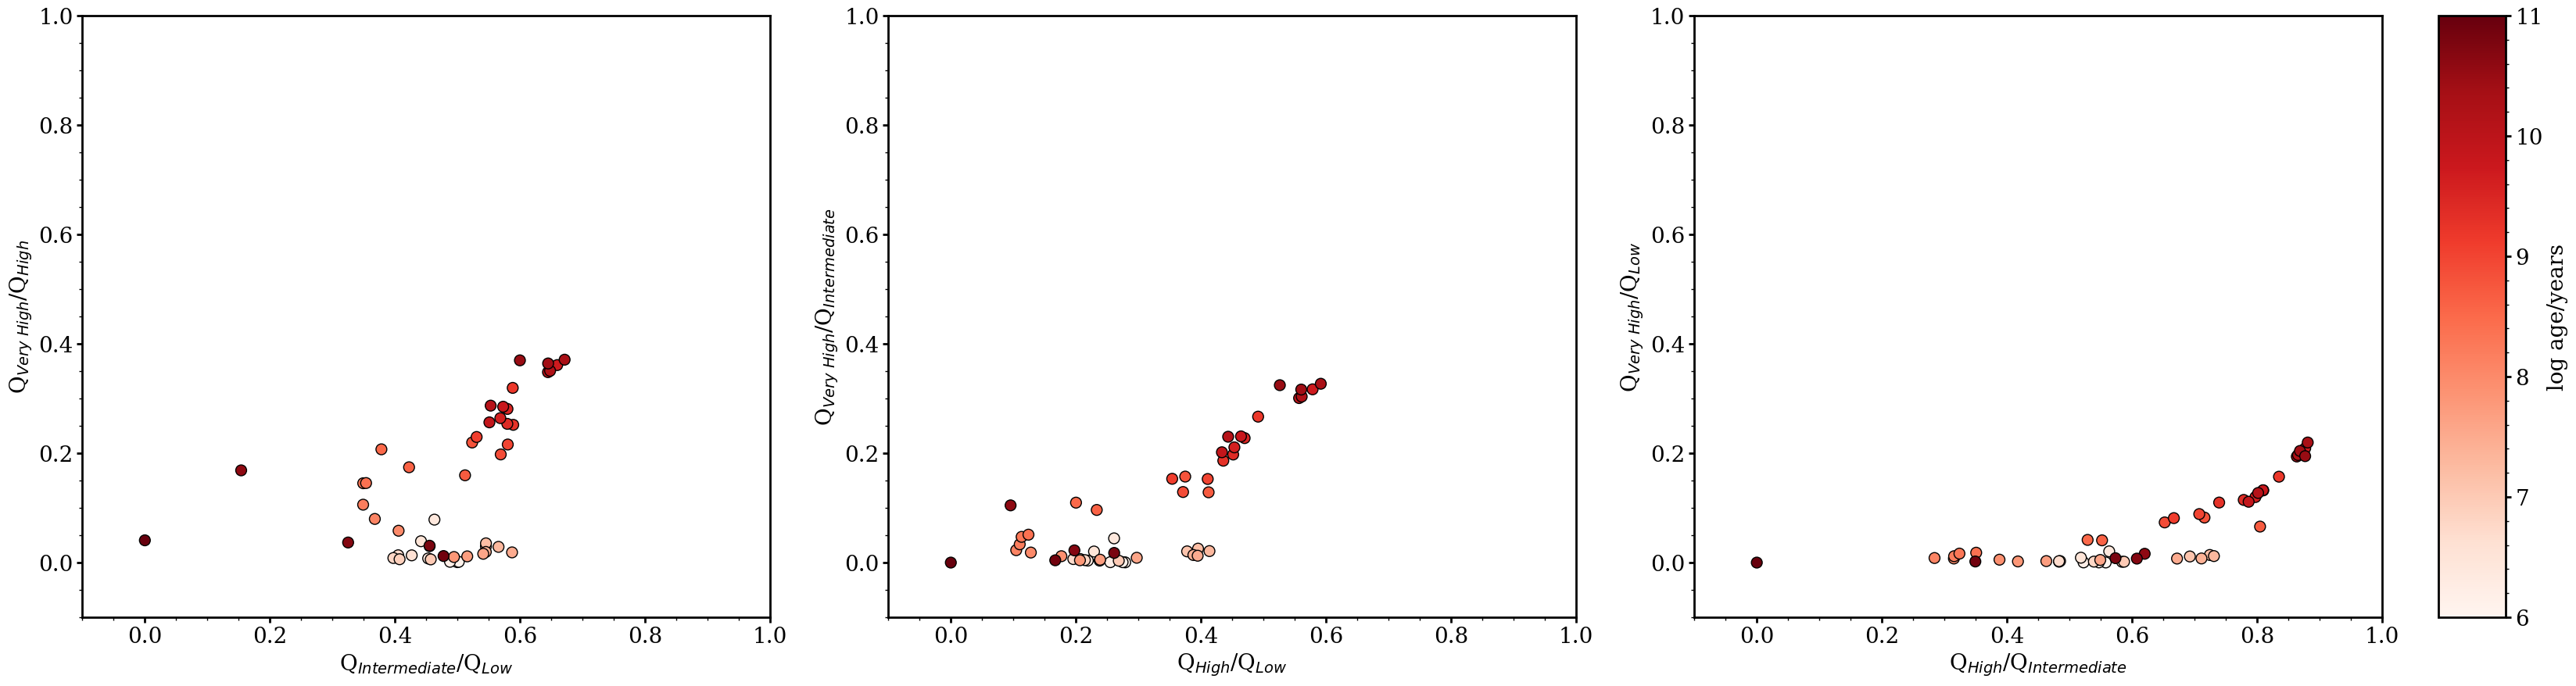

In [7]:
fig = plt.figure(figsize = (40 , 10))
gs = GridSpec(nrows=10, ncols=40)
gs.update(wspace=10, hspace=0)

ax = fig.add_subplot(gs[0:10, 0:12])
y = ax.scatter(integrals_df.loc['intermediate']/integrals_df.loc['low'], integrals_df.loc['very_high']/integrals_df.loc['high'], c=integrals_df.columns, ec='k', cmap='Reds', s=100)
ax.axis([-0.1,1,-0.1,1])
ax.set_xlabel('Q$_{Intermediate}$/Q$_{Low}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{High}$')

ax = fig.add_subplot(gs[0:10, 13:25])
ax.scatter(integrals_df.loc['high']/integrals_df.loc['low'], integrals_df.loc['very_high']/integrals_df.loc['intermediate'], c=integrals_df.columns, ec='k', cmap='Reds', s=100)
ax.axis([-0.1,1,-0.1,1])
ax.set_xlabel('Q$_{High}$/Q$_{Low}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{Intermediate}$')

ax = fig.add_subplot(gs[0:10, 26:38])
ax.scatter(integrals_df.loc['high']/integrals_df.loc['intermediate'], integrals_df.loc['very_high']/integrals_df.loc['low'], c=integrals_df.columns, ec='k', cmap='Reds', s=100)
ax.set_xlabel('Q$_{High}$/Q$_{Intermediate}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{Low}$')
ax.axis([-0.1,1,-0.1,1])

ax = fig.add_subplot(gs[0:10,38:40])
fig.colorbar(y,ax,use_gridspec=True,  label='log age/years')

plt.show()

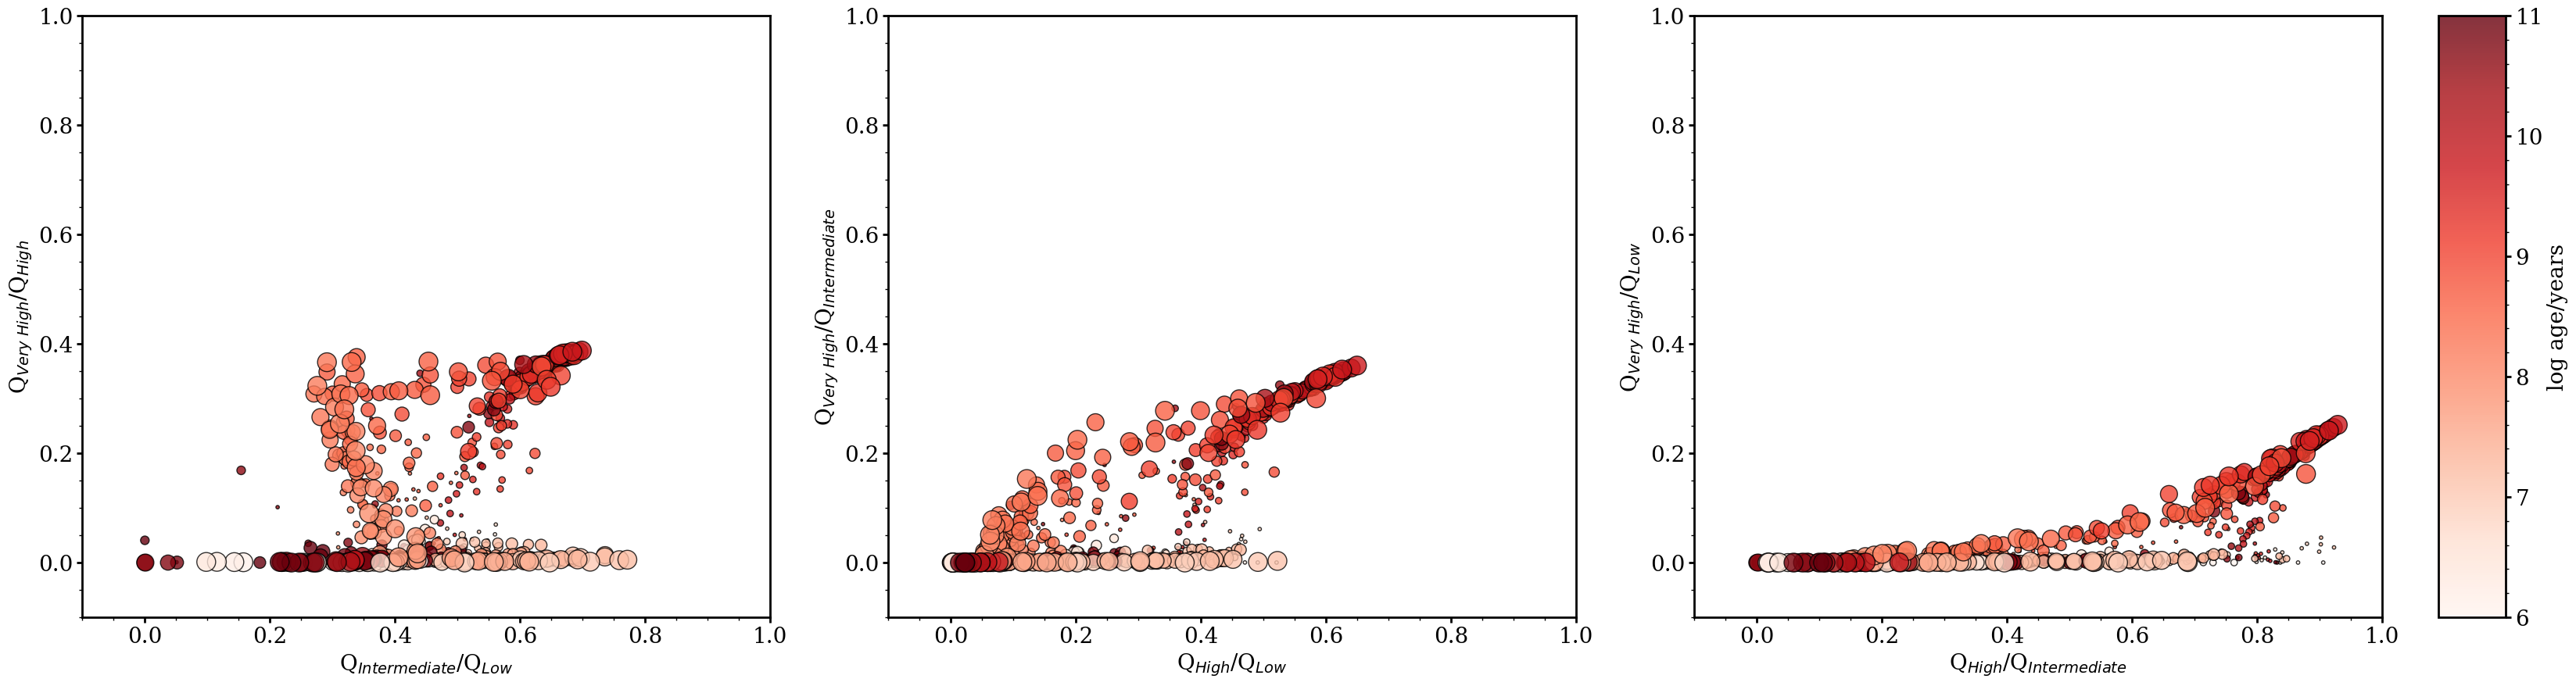

In [8]:
Z_ALL = ['em5', 'em4', '001', '002', '003', '004', '006', '008', '010', '014', '020', '040']
z_size = np.linspace(10, 300, len(Z_ALL))
for z in Z_ALL:
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)


fig = plt.figure(figsize = (40 , 10))
gs = GridSpec(nrows=10, ncols=40)
gs.update(wspace=10, hspace=0)

ax = fig.add_subplot(gs[0:10, 0:12])
for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    y = ax.scatter(integrals_df.loc['intermediate']/integrals_df.loc['low'], integrals_df.loc['very_high']/integrals_df.loc['high'], c=integrals_df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8)
ax.axis([-0.1,1,-0.1,1])
ax.set_xlabel('Q$_{Intermediate}$/Q$_{Low}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{High}$')

ax = fig.add_subplot(gs[0:10, 13:25])
for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    ax.scatter(integrals_df.loc['high']/integrals_df.loc['low'], integrals_df.loc['very_high']/integrals_df.loc['intermediate'], c=integrals_df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8)
ax.axis([-0.1,1,-0.1,1])
ax.set_xlabel('Q$_{High}$/Q$_{Low}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{Intermediate}$')

ax = fig.add_subplot(gs[0:10, 26:38])
for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    ax.scatter(integrals_df.loc['high']/integrals_df.loc['intermediate'], integrals_df.loc['very_high']/integrals_df.loc['low'], c=integrals_df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8)
ax.set_xlabel('Q$_{High}$/Q$_{Intermediate}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{Low}$')
ax.axis([-0.1,1,-0.1,1])

ax = fig.add_subplot(gs[0:10,38:40])
fig.colorbar(y,ax,use_gridspec=True,  label='log age/years')

plt.show()

In [ ]:
AGN_SEDs = '/Users/njc5787/Research/cloudy_modeling/agn_seds/'
df = pd.read_csv(AGN_SEDs+f'mbh{3}.txt', sep='\t+', names=['nu', 'nuFnu', 'other']).drop(0, axis=0).drop('other', axis=1).astype(float)
df['wavelength'] = 2.99792e18/df['nu']
df


,wavelength
1,123984.977440
2,3023.995075
3,1530.663994
4,1024.659327
5,770.085566
...,...
99996,0.030997
99997,0.030997
99998,0.030997
99999,0.030997


(0.0, 912.0)

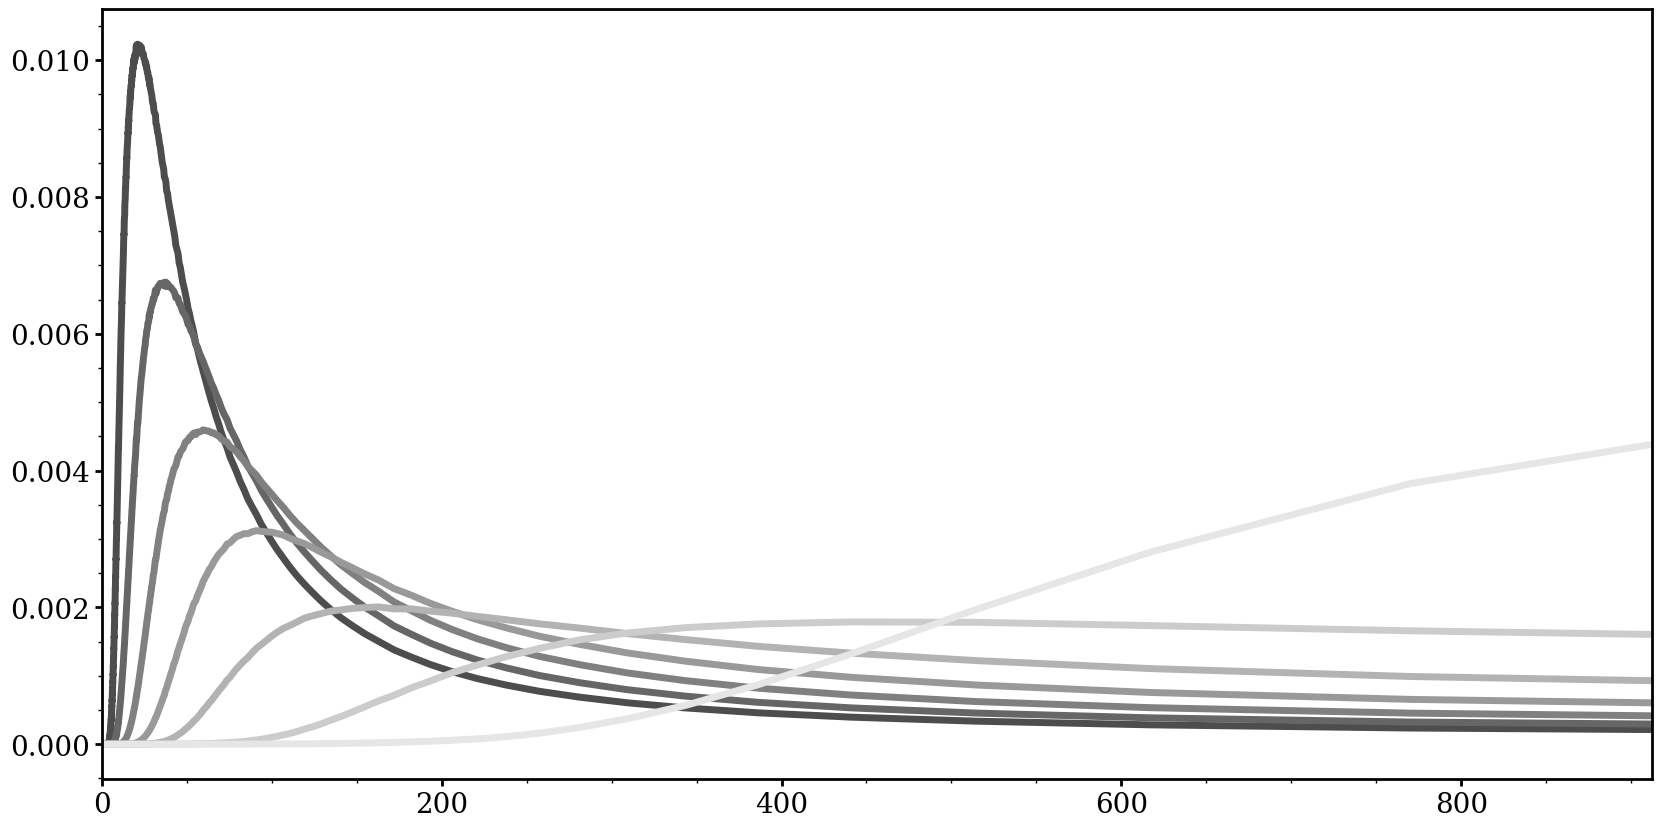

In [93]:

plt.figure(figsize=(20,10))
plt.plot(mbh_seds['wavelength'], mbh_seds[3]/mbh_integrals.loc['total'][3], c='0.3', lw=5)
plt.plot(mbh_seds['wavelength'], mbh_seds[4]/mbh_integrals.loc['total'][4], c='0.4', lw=5)
plt.plot(mbh_seds['wavelength'], mbh_seds[5]/mbh_integrals.loc['total'][5], c='0.5', lw=5)
plt.plot(mbh_seds['wavelength'], mbh_seds[6]/mbh_integrals.loc['total'][6], c='0.6', lw=5)
plt.plot(mbh_seds['wavelength'], mbh_seds[7]/mbh_integrals.loc['total'][7], c='0.7', lw=5)
plt.plot(mbh_seds['wavelength'], mbh_seds[8]/mbh_integrals.loc['total'][8], c='0.8', lw=5)
plt.plot(mbh_seds['wavelength'], mbh_seds[9]/mbh_integrals.loc['total'][9], c='0.9', lw=5)

plt.xlim(0, 912)

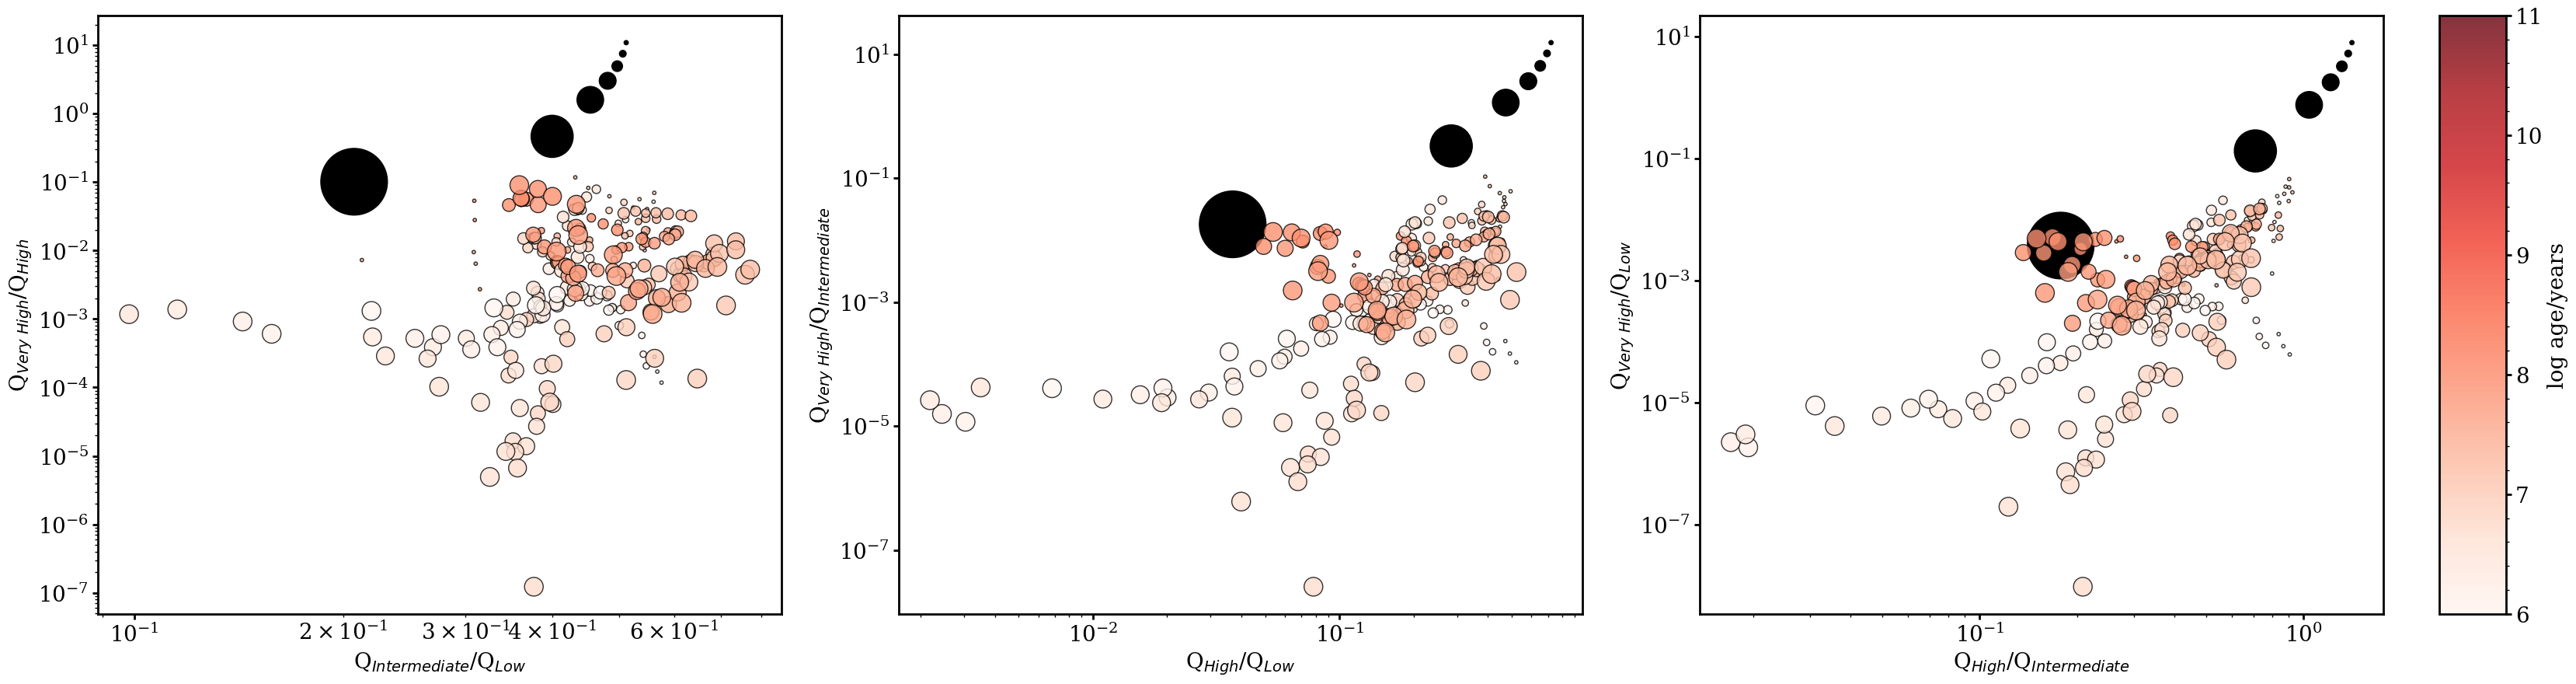

In [10]:
fig = plt.figure(figsize = (40 , 10))
gs = GridSpec(nrows=10, ncols=40)
gs.update(wspace=10, hspace=0)

ax0 = fig.add_subplot(gs[0:10, 0:12])
ax0.scatter(mbh_integrals.loc['intermediate']/mbh_integrals.loc['low'], mbh_integrals.loc['very_high']/mbh_integrals.loc['high'], c='k', ec='k', s=2.5**mbh_integrals.columns)
# ax0.axis([1e-1,1e0,1e-5,5e1])
ax0.set_xlabel('Q$_{Intermediate}$/Q$_{Low}$')
ax0.set_ylabel('Q$_{Very~High}$/Q$_{High}$')
ax0.set_xscale('log')
ax0.set_yscale('log')

ax1 = fig.add_subplot(gs[0:10, 13:25])
ax1.scatter(mbh_integrals.loc['high']/mbh_integrals.loc['low'], mbh_integrals.loc['very_high']/mbh_integrals.loc['intermediate'], c='k', ec='k', s=2.5**mbh_integrals.columns)
# ax1.axis([5e-3,3e0,1e-5,5e1])
ax1.set_xlabel('Q$_{High}$/Q$_{Low}$')
ax1.set_ylabel('Q$_{Very~High}$/Q$_{Intermediate}$')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig.add_subplot(gs[0:10, 26:38])
ax2.scatter(mbh_integrals.loc['high']/mbh_integrals.loc['intermediate'], mbh_integrals.loc['very_high']/mbh_integrals.loc['low'], c='k', ec='k', s=2.5**mbh_integrals.columns)
ax2.set_xlabel('Q$_{High}$/Q$_{Intermediate}$')
ax2.set_ylabel('Q$_{Very~High}$/Q$_{Low}$')
# ax2.axis([5e-2,3e0,1e-5,5e1])
ax2.set_xscale('log')
ax2.set_yscale('log')

for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    agelessthan8df = integrals_df.drop(integrals_df.columns[20:], axis=1).copy()
    y = ax0.scatter(agelessthan8df.loc['intermediate']/agelessthan8df.loc['low'], agelessthan8df.loc['very_high']/agelessthan8df.loc['high'], c=agelessthan8df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8, vmin=6, vmax=11)
    ax1.scatter(agelessthan8df.loc['high']/agelessthan8df.loc['low'], agelessthan8df.loc['very_high']/agelessthan8df.loc['intermediate'], c=agelessthan8df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8, vmin=6, vmax=11)
    ax2.scatter(agelessthan8df.loc['high']/agelessthan8df.loc['intermediate'], agelessthan8df.loc['very_high']/agelessthan8df.loc['low'], c=agelessthan8df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8, vmin=6, vmax=11)


ax = fig.add_subplot(gs[0:10,38:40])
fig.colorbar(y,ax,use_gridspec=True, label='log age/years')

plt.savefig('Qthreepanel.pdf')

plt.show()

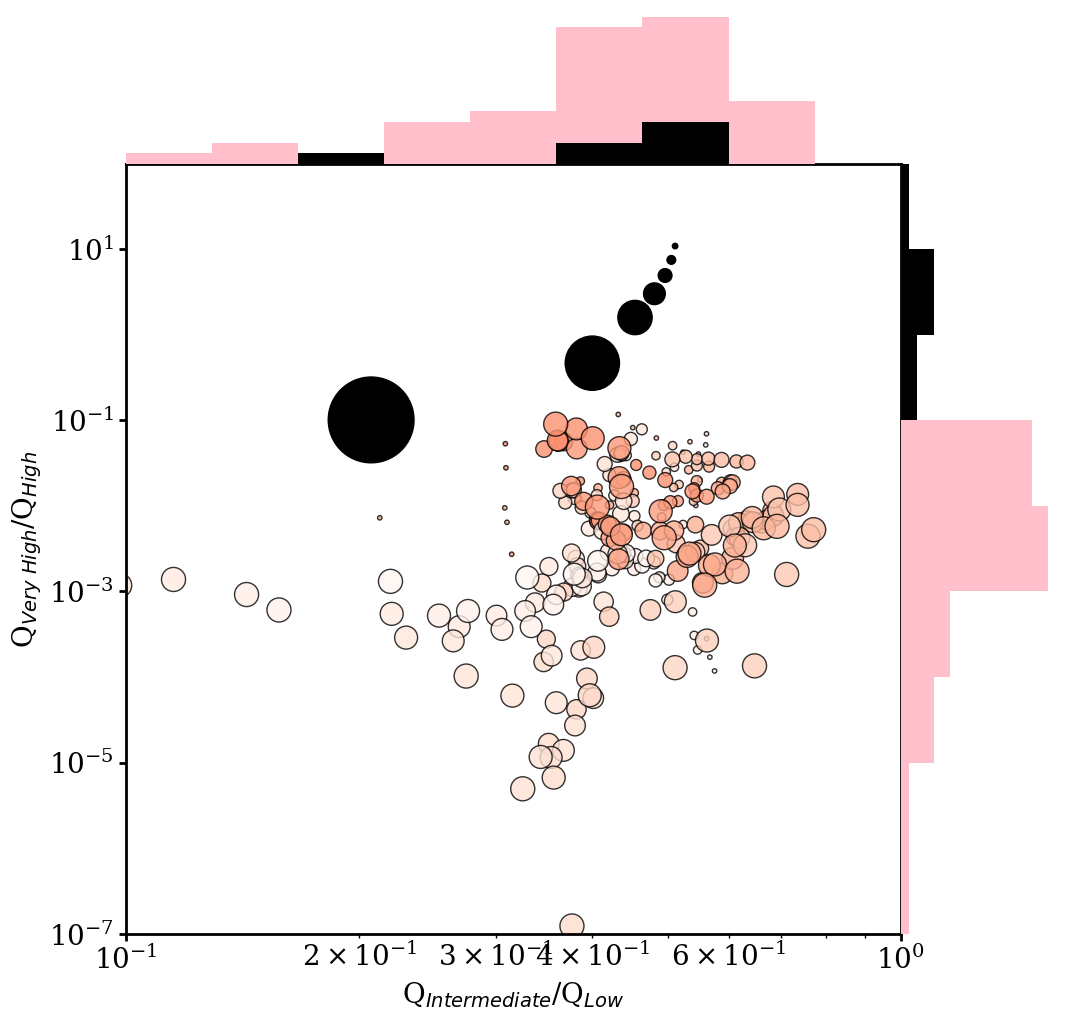

In [11]:
fig = plt.figure(figsize = (12 , 12))
gs = GridSpec(nrows=12, ncols=12)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[2:12, 0:10])
ax.scatter(mbh_integrals.loc['intermediate']/mbh_integrals.loc['low'], mbh_integrals.loc['very_high']/mbh_integrals.loc['high'], c='k', ec='k', s=2.5**mbh_integrals.columns)
# ax.axis([1e-1,1e0,1e-5,5e1])
ax.set_xlim(1e-1, 1e0)
ax.set_ylim(1e-7, 1e2)
ax.set_xlabel('Q$_{Intermediate}$/Q$_{Low}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{High}$')
ax.set_xscale('log')
ax.set_yscale('log')

ax_top = fig.add_subplot(gs[0:2, 0:10])
ax_top.axis('off')
# ax_top.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
ax_top.set_xlim(1e-1, 1e0)
# ax_top.set_yscale('log')
ax_top.set_xscale('log')
ax_top.hist(mbh_integrals.loc['intermediate']/mbh_integrals.loc['low'], bins=np.logspace(-1, 0, 10), color='k', alpha=1)

ax_right = fig.add_subplot(gs[2:12, 10:12])
ax_right.axis('off')
# ax_right.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
ax_right.set_ylim(1e-7, 1e2)
ax_right.set_yscale('log')
# ax_right.set_xscale('log')
ax_right.hist(mbh_integrals.loc['very_high']/mbh_integrals.loc['high'], bins=np.logspace(-7, 2, 10), color='k', alpha=1, orientation='horizontal')

for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    agelessthan8df = integrals_df.drop(integrals_df.columns[20:], axis=1).copy()

    y = ax.scatter(agelessthan8df.loc['intermediate']/agelessthan8df.loc['low'], agelessthan8df.loc['very_high']/agelessthan8df.loc['high'], c=agelessthan8df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8, vmin=6, vmax=11)
    ax_top.hist(agelessthan8df.loc['intermediate']/agelessthan8df.loc['low'], bins=np.logspace(-1, 0, 10), color='pink', zorder=-9)
    ax_right.hist(agelessthan8df.loc['very_high']/agelessthan8df.loc['high'], bins=np.logspace(-7, 2, 10), color='pink', orientation='horizontal', zorder=-9)

plt.savefig('QvhQh_QiQl.pdf')
plt.show()




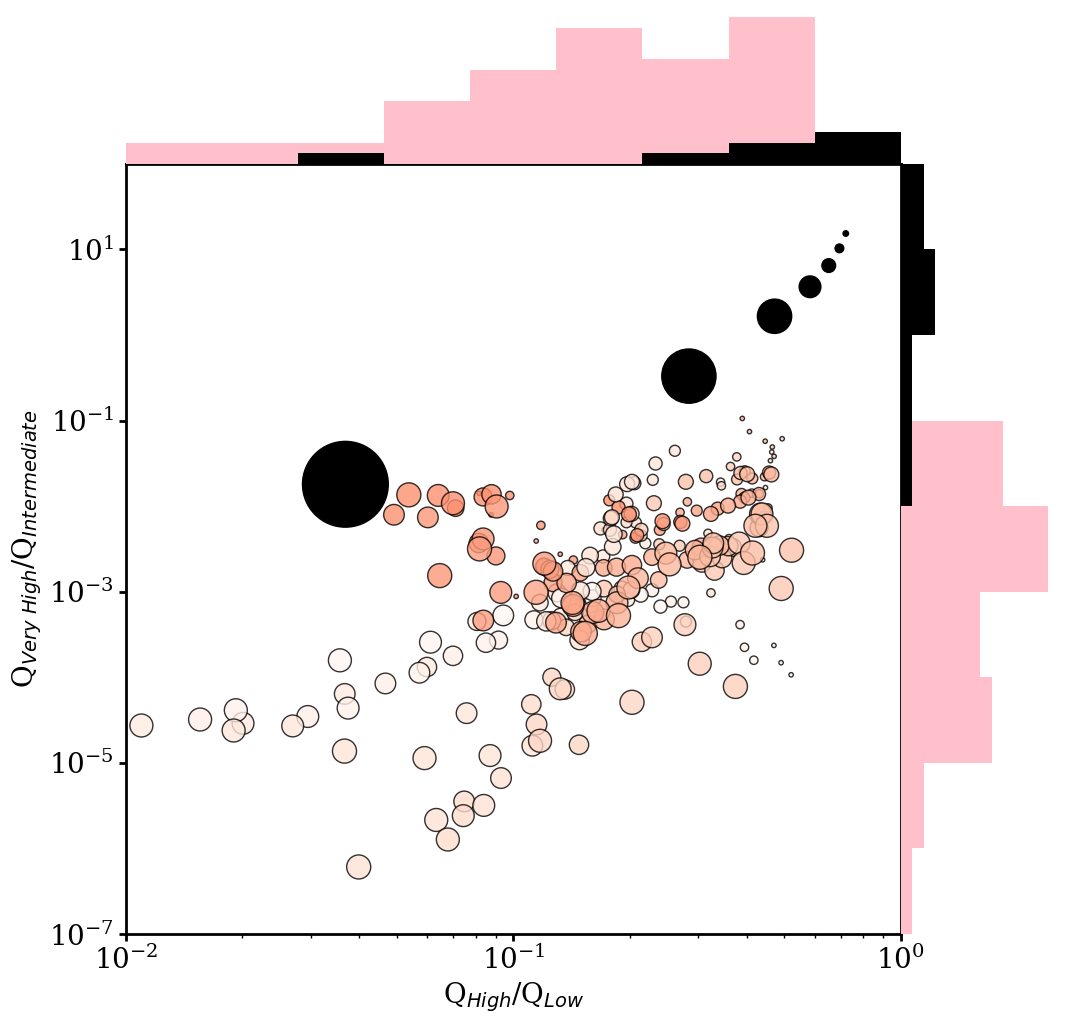

In [237]:
fig = plt.figure(figsize = (12 , 12))
gs = GridSpec(nrows=12, ncols=12)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[2:12, 0:10])
ax.scatter(mbh_integrals.loc['high']/mbh_integrals.loc['low'], mbh_integrals.loc['very_high']/mbh_integrals.loc['intermediate'], c='k', ec='k', s=2.5**mbh_integrals.columns)
# ax.axis([1e-1,1e0,1e-5,5e1])
ax.set_xlim(1e-2, 1e0)
ax.set_ylim(1e-7, 1e2)
ax.set_xlabel('Q$_{High}$/Q$_{Low}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{Intermediate}$')
ax.set_xscale('log')
ax.set_yscale('log')

ax_top = fig.add_subplot(gs[0:2, 0:10])
ax_top.axis('off')
# ax_top.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
ax_top.set_xlim(1e-2, 1e0)
# ax_top.set_yscale('log')
ax_top.set_xscale('log')
ax_top.hist(mbh_integrals.loc['high']/mbh_integrals.loc['low'], bins=np.logspace(-2, 0, 10), color='k', alpha=1)

ax_right = fig.add_subplot(gs[2:12, 10:12])
ax_right.axis('off')
ax_right.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
ax_right.set_ylim(1e-7, 1e2)
ax_right.set_yscale('log')
# ax_right.set_xscale('log')
ax_right.hist(mbh_integrals.loc['very_high']/mbh_integrals.loc['intermediate'], bins=np.logspace(-7, 2, 10), color='k', alpha=1, orientation='horizontal')

for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    agelessthan8df = integrals_df.drop(integrals_df.columns[20:], axis=1).copy()

    y = ax.scatter(agelessthan8df.loc['high']/agelessthan8df.loc['low'], agelessthan8df.loc['very_high']/agelessthan8df.loc['intermediate'], c=agelessthan8df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8, vmin=6, vmax=11)
    ax_top.hist(agelessthan8df.loc['high']/agelessthan8df.loc['low'], bins=np.logspace(-2, 0, 10), color='pink', zorder=-9)
    ax_right.hist(agelessthan8df.loc['very_high']/agelessthan8df.loc['intermediate'], bins=np.logspace(-7, 2, 10), color='pink', orientation='horizontal', zorder=-9)


plt.show()

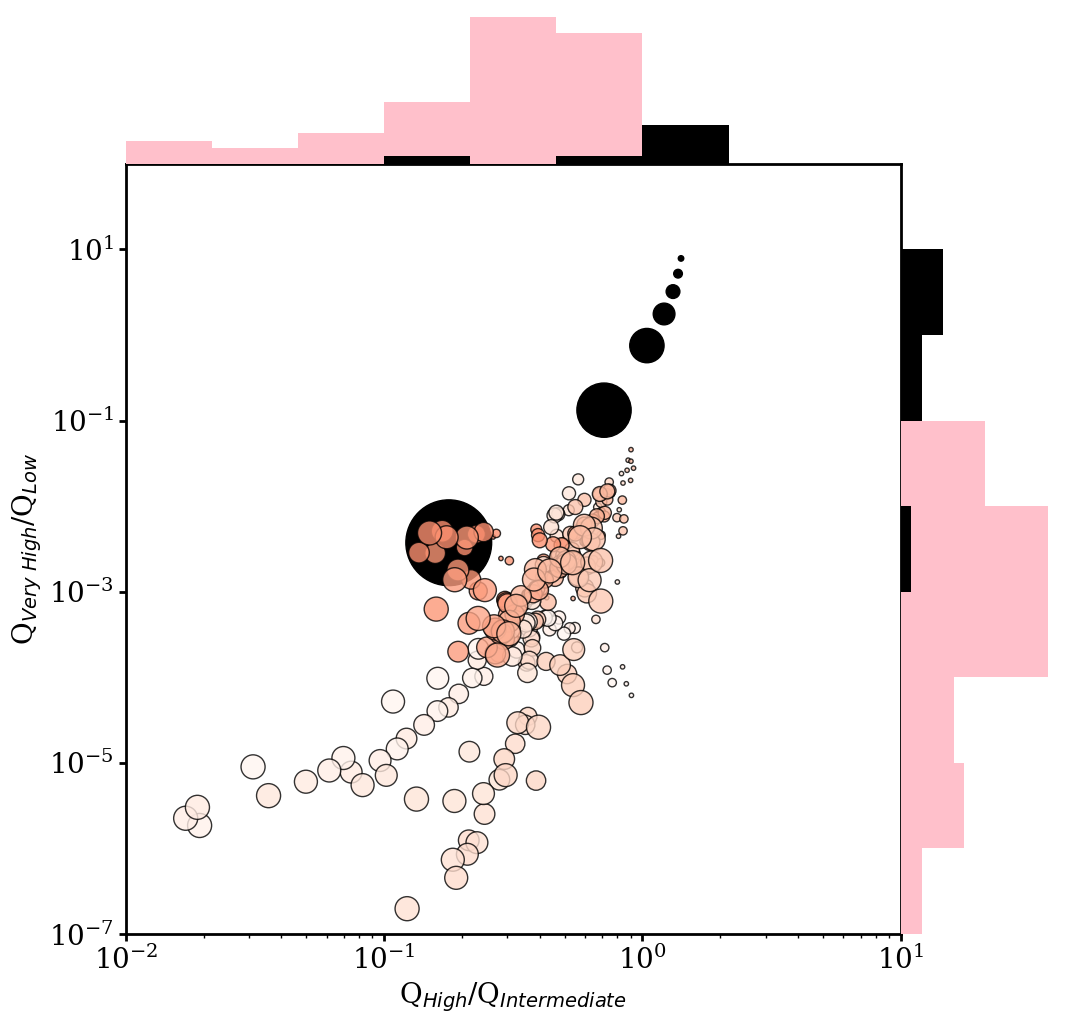

In [236]:
fig = plt.figure(figsize = (12 , 12))
gs = GridSpec(nrows=12, ncols=12)
gs.update(wspace=0, hspace=0)

ax = fig.add_subplot(gs[2:12, 0:10])
ax.scatter(mbh_integrals.loc['high']/mbh_integrals.loc['intermediate'], mbh_integrals.loc['very_high']/mbh_integrals.loc['low'], c='k', ec='k', s=2.5**mbh_integrals.columns)
# ax.axis([1e-1,1e0,1e-5,5e1])
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(1e-7, 1e2)
ax.set_xlabel('Q$_{High}$/Q$_{Intermediate}$')
ax.set_ylabel('Q$_{Very~High}$/Q$_{Low}$')
ax.set_xscale('log')
ax.set_yscale('log')

ax_top = fig.add_subplot(gs[0:2, 0:10])
ax_top.axis('off')
# ax_top.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
ax_top.set_xlim(1e-2, 1e1)
# ax_top.set_yscale('log')
ax_top.set_xscale('log')
ax_top.hist(mbh_integrals.loc['high']/mbh_integrals.loc['intermediate'], bins=np.logspace(-2, 1, 10), color='k', alpha=1)

ax_right = fig.add_subplot(gs[2:12, 10:12])
ax_right.axis('off')
# ax_right.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
ax_right.set_ylim(1e-7, 1e2)
ax_right.set_yscale('log')
# ax_right.set_xscale('log')
ax_right.hist(mbh_integrals.loc['very_high']/mbh_integrals.loc['low'], bins=np.logspace(-7, 2, 10), color='k', alpha=1, orientation='horizontal')

for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    agelessthan8df = integrals_df.drop(integrals_df.columns[20:], axis=1).copy()

    y = ax.scatter(agelessthan8df.loc['high']/agelessthan8df.loc['intermediate'], agelessthan8df.loc['very_high']/agelessthan8df.loc['low'], c=agelessthan8df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8, vmin=6, vmax=11)
    ax_top.hist(agelessthan8df.loc['high']/agelessthan8df.loc['intermediate'], bins=np.logspace(-2, 1, 10), color='pink', zorder=-9)
    ax_right.hist(agelessthan8df.loc['very_high']/agelessthan8df.loc['low'], bins=np.logspace(-7, 2, 10), color='pink',orientation='horizontal', zorder=-9)


plt.show()

In [ ]:
Z_ALL = ['em5', 'em4', '001', '002', '003', '004', '006', '008', '010', '014', '020', '040']

z_size = np.linspace(10, 300, len(Z_ALL))
for z in Z_ALL:
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)

mbhs = [3,4,5,6,7,8,9]
mbh_seds = pd.DataFrame()
for mbh in mbhs:
    df = pd.read_csv(AGN_SEDs+f'mbh{mbh}.txt', sep='\t+', names=['nu', 'nuFnu', 'other']).drop(0, axis=0).drop('other', axis=1).astype(float)
    mbh_seds[mbh] = df['nuFnu']
mbh_seds['wavelength'] = 2.99792e18/df['nu']
mbh_integrals = generate_ionization_zone_integrals_mbh(mbh_seds)

fig = plt.figure(figsize = (40 , 10))
gs = GridSpec(nrows=10, ncols=40)
gs.update(wspace=10, hspace=0)

ax0 = fig.add_subplot(gs[0:10, 0:12])
ax0.scatter(mbh_integrals.loc['intermediate']/mbh_integrals.loc['low'], mbh_integrals.loc['very_high']/mbh_integrals.loc['high'], c='k', ec='k', s=2.5**mbh_integrals.columns)
ax0.axis([1e-1,1e0,1e-5,5e1])
ax0.set_xlabel('Q$_{Intermediate}$/Q$_{Low}$')
ax0.set_ylabel('Q$_{Very~High}$/Q$_{High}$')
ax0.set_xscale('log')
ax0.set_yscale('log')

ax1 = fig.add_subplot(gs[0:10, 13:25])
ax1.scatter(mbh_integrals.loc['high']/mbh_integrals.loc['low'], mbh_integrals.loc['very_high']/mbh_integrals.loc['intermediate'], c='k', ec='k', s=2.5**mbh_integrals.columns)
ax1.axis([5e-3,3e0,1e-5,5e1])
ax1.set_xlabel('Q$_{High}$/Q$_{Low}$')
ax1.set_ylabel('Q$_{Very~High}$/Q$_{Intermediate}$')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig.add_subplot(gs[0:10, 26:38])
ax2.scatter(mbh_integrals.loc['high']/mbh_integrals.loc['intermediate'], mbh_integrals.loc['very_high']/mbh_integrals.loc['low'], c='k', ec='k', s=2.5**mbh_integrals.columns)
ax2.set_xlabel('Q$_{High}$/Q$_{Intermediate}$')
ax2.set_ylabel('Q$_{Very~High}$/Q$_{Low}$')
ax2.axis([5e-2,3e0,1e-5,5e1])
ax2.set_xscale('log')
ax2.set_yscale('log')

for i,z in enumerate(Z_ALL):
    bpass_df = format_bpass_sed(BPASS_seds+f'spectra-bin-imf135_300.z{z}.dat')
    integrals_df = generate_ionization_zone_integrals(seds=bpass_df)
    y = ax0.scatter(integrals_df.loc['intermediate']/integrals_df.loc['low'], integrals_df.loc['very_high']/integrals_df.loc['high'], c=integrals_df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8)
    ax1.scatter(integrals_df.loc['high']/integrals_df.loc['low'], integrals_df.loc['very_high']/integrals_df.loc['intermediate'], c=integrals_df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8)
    ax2.scatter(integrals_df.loc['high']/integrals_df.loc['intermediate'], integrals_df.loc['very_high']/integrals_df.loc['low'], c=integrals_df.columns, ec='k', cmap='Reds', s=z_size[i], alpha=0.8)


ax = fig.add_subplot(gs[0:10,38:40])
fig.colorbar(y,ax,use_gridspec=True,  label='log age/years')

plt.show()